<h1><center>YOLO V5 Car Object Detection</center></h1>

<img src="https://pjreddie.com/media/image/yologo_2.png" width="400" height="400" />


<div style="text-align: right"> Source: https://pjreddie.com/</div>

### Libraries 📚⬇

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 4072 (delta 23), reused 23 (delta 11), pack-reused 4027
Receiving objects: 100% (4072/4072), 7.28 MiB | 11.21 MiB/s, done.
Resolving deltas: 100% (2745/2745), done.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=273754 sha256=a8dbfb817b783b10323acf6a25358f610ebe62ee505b39a773d0a1d35caf345d
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the

## Loading Data 📝 / Preprocessing ⚙️

In [3]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [4]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_18840


(380, 676, 3)

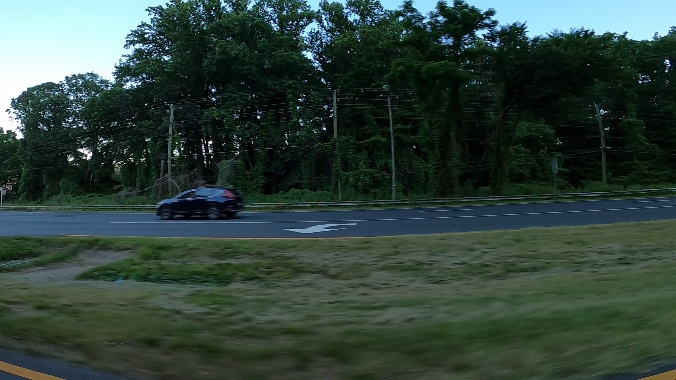

In [5]:
image = random.choice(index)
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

## Training (Work in Progress)

In [6]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/kaggle/input/car-object-detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [7]:
#!python train.py --batch 2 --epochs 1 --data ../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new

## Prediction

In [8]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=676, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/input/car-object-detection/data/testing_images', update=False, view_img=False, weights=['yolov5/yolov5s.pt'])
/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 15.0MB/s]

Fusing layers... 
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 416x704 Done. (0.222s)
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 416x704 Done. (0.210

image 64/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27840.jpg: 416x704 1 cars, Done. (0.212s)
image 65/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27860.jpg: 416x704 1 cars, Done. (0.199s)
image 66/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27880.jpg: 416x704 1 cars, Done. (0.197s)
image 67/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27900.jpg: 416x704 1 cars, Done. (0.204s)
image 68/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27920.jpg: 416x704 1 cars, Done. (0.197s)
image 69/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27940.jpg: 416x704 1 cars, Done. (0.192s)
image 70/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27960.jpg: 416x704 Done. (0.207s)
image 71/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_27980.jpg: 416x704 1 chairs, Done. (0.214s)
image 72/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_2800

image 137/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30720.jpg: 416x704 Done. (0.192s)
image 138/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30740.jpg: 416x704 1 cars, 1 trucks, Done. (0.204s)
image 139/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30760.jpg: 416x704 1 cars, 4 traffic lights, Done. (0.203s)
image 140/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30820.jpg: 416x704 3 cars, 6 traffic lights, Done. (0.200s)
image 141/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30840.jpg: 416x704 2 cars, 5 traffic lights, Done. (0.201s)
image 142/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30860.jpg: 416x704 3 cars, 3 traffic lights, Done. (0.200s)
image 143/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30920.jpg: 416x704 2 cars, 2 traffic lights, Done. (0.201s)
image 144/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_30940.jpg: 416

In [17]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("runs/detect/exp"):
    predicted_files.extend(filenames)

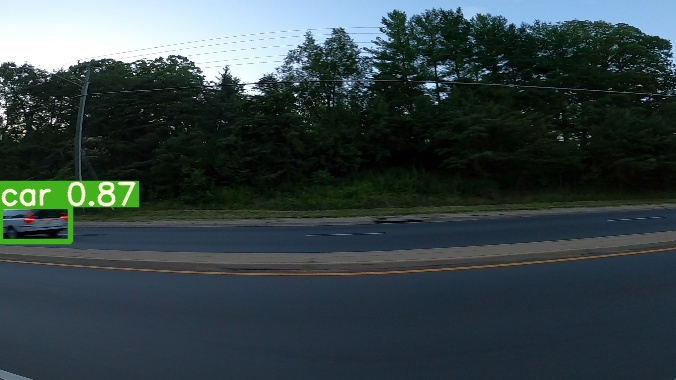

In [20]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

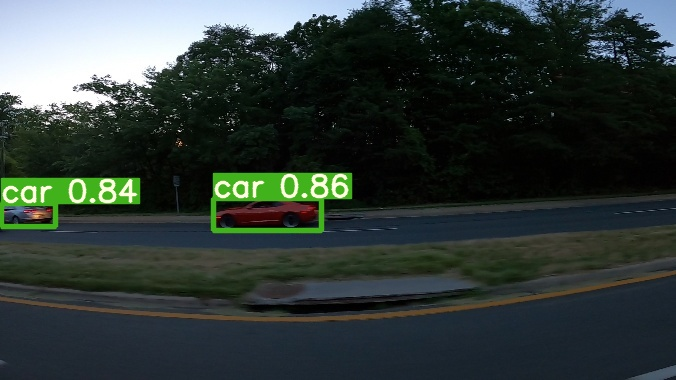

In [29]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

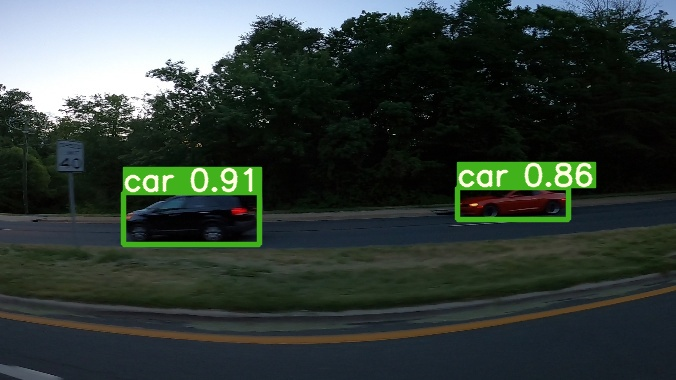

In [30]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

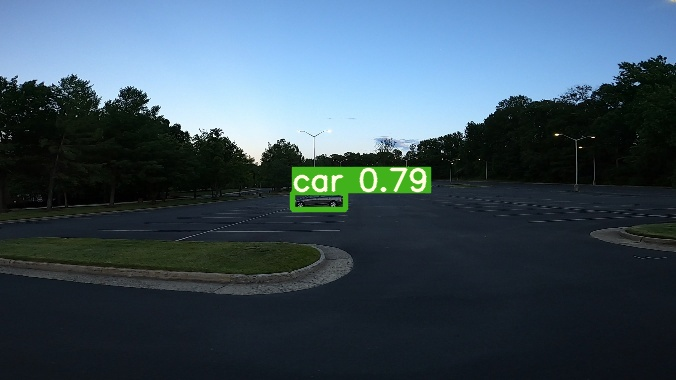

In [31]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

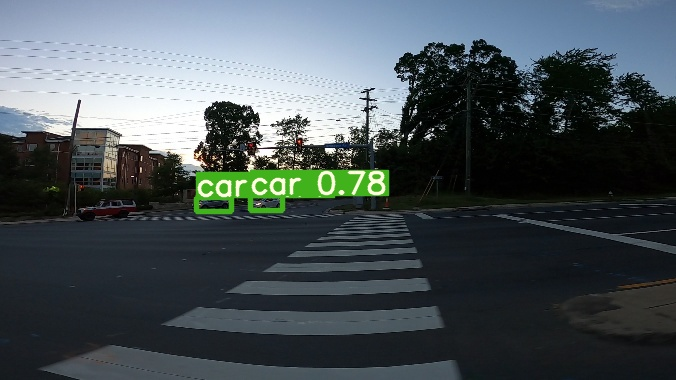

In [33]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

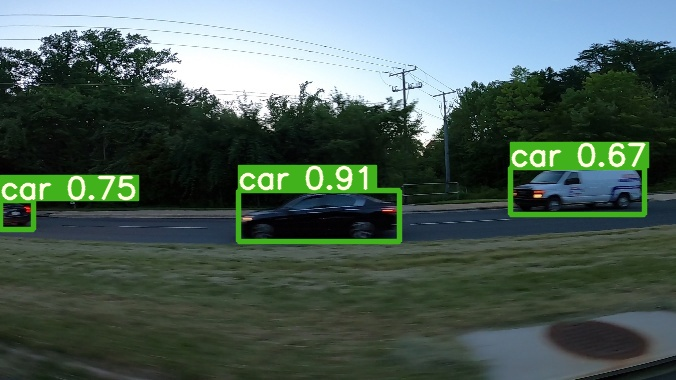

In [39]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

In [40]:
!rm -rf runs yolov5

### Work in Progress

### If you found this kernel helpful, please upvote it 🚞